### Get spectral peaks for the data

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_coupling_analysis")

In [2]:
import argparse
import os

import numpy as np
import xarray as xr
from frites.conn import conn_links
from scipy.signal import find_peaks
from tqdm import tqdm

from src.util import get_dates

###############################################################################
##### Functions
###############################################################################

In [3]:
def detect_peak_frequencies(
    power=None, absolute_power=None, prominence=0.01, verbose=False
):

    assert power.ndim == 2
    assert isinstance(power, xr.DataArray)

    roi, freqs = power.roi.data, power.freqs.data
    n_roi = len(roi)

    rois = []
    peak_power = []
    peak_freqs = []
    peak_prominences = []

    __iter = range(n_roi)
    for i in tqdm(__iter) if verbose else __iter:
        peak_index, peak_info = find_peaks(power[i, :], prominence=prominence)
        peak_power += [absolute_power[i, :][peak_index]]
        peak_freqs += [freqs[peak_index]]
        peak_prominences += [peak_info["prominences"]]
        rois += [[roi[i]] * len(peak_index)]

    return peak_power, peak_freqs, peak_prominences, rois


def check_peaks(peak_power, peak_freqs, peak_prominences, rois):

    has_peak = np.zeros((average_power_norm.sizes["roi"], len(bands)), dtype=bool)

    for i in range(average_power_norm.sizes["roi"]):
        for peak in peak_freqs[i]:
            for n_band, band in enumerate(bands.keys()):
                if not has_peak[i, n_band]:
                    has_peak[i, n_band] = bands[band][0] <= peak <= bands[band][1]

    has_peak = xr.DataArray(
        has_peak,
        dims=("roi", "bands"),
        coords=(average_power_norm.roi, list(bands.keys())),
    )

    peak_power = xr.DataArray(
        np.hstack(peak_power),
        dims="roi",
        coords={"roi": np.hstack(rois)},
        name="peak_freq",
    )

    peak_freqs = xr.DataArray(
        np.hstack(peak_freqs),
        dims="roi",
        coords={"roi": np.hstack(rois)},
        name="peak_freq",
    )

    peak_prominences = xr.DataArray(
        np.hstack(peak_prominences),
        dims="roi",
        coords={"roi": np.hstack(rois)},
        name="peak_prom",
    )

    return has_peak, peak_freqs, peak_prominences, peak_power

###############################################################################
##### Get session and monkey
###############################################################################

In [4]:
n = "cue"
monkey = "lucy"
session_number = get_dates(monkey)[11]

In [5]:
average_power_epochs = xr.load_dataarray(
    f"/home/INT/lima.v/Results/phase_encoding/psd/{monkey}/{session_number}/sxx.nc"
)

In [6]:
###############################################################################
##### Find spectral peaks
###############################################################################

In [7]:
# Define bands
bands = {
    "theta": [0, 6],
    "alpha": [6, 14],
    "beta_1": [14, 26],
    "beta_2": [26, 43],
    "gamma": [43, 80],
}

In [8]:
# Normalize spectra
average_power_norm = average_power_epochs / average_power_epochs.max("freqs")

unique_rois = average_power_norm.roi.values

In [9]:
peak_power, peak_freqs, peak_prominences, rois = [], [], [], []

for average_power_norm_, average_power_epochs_ in zip(
    average_power_norm, average_power_epochs
):
    out0, out1, out2, out3 = detect_peak_frequencies(
        average_power_norm_, average_power_epochs_, prominence=0.01
    )
    peak_power += [out0]
    peak_freqs += [out1]
    peak_prominences += [out2]
    rois += [out3]

In [10]:
# Do it for each epoch
has_peaks = []
freqs_array = []
prominences_array = []
power_array = []

for i in range(5):
    out = check_peaks(peak_power[i], peak_freqs[i], peak_prominences[i], rois[i])
    has_peaks += [out[0]]
    freqs_array += [out[1]]
    prominences_array += [out[2]]
    power_array += [out[3]]


has_peaks = xr.DataArray(
    np.stack(has_peaks, axis=1).squeeze(),
    dims=("roi", "epochs", "bands"),
    coords={"roi": average_power_norm.roi.data},
)

###########################################################################
##### Concatenate peak freq and prominences for each epoch
###########################################################################

In [11]:
peak_freqs = np.zeros((5, len(unique_rois)))
peak_power = np.zeros((5, len(unique_rois)))

for i in range(5):
    for j, roi_ in enumerate(unique_rois):
        try:
            index = int(prominences_array[i].sel(roi=roi_).argmax())
            peak_freqs[i, j] = np.atleast_1d(freqs_array[i].sel(roi=roi_).values)[index]
            peak_power[i, j] = np.atleast_1d(power_array[i].sel(roi=roi_).values)[index]
        except:
            peak_freqs[i, j] = np.nan
            peak_power[i, j] = np.nan

peak_freqs = xr.DataArray(
    peak_freqs, dims=("epochs", "roi"), coords={"roi": unique_rois}
)

peak_power = xr.DataArray(
    peak_power, dims=("epochs", "roi"), coords={"roi": unique_rois}
)

###########################################################################
#### All sessions
###########################################################################

In [33]:
session_numbers = get_dates(monkey)

for session_number in tqdm(session_numbers):

    ####################################################### SAVE PATH #######################################################
    _SAVE = os.path.expanduser(
        f"/home/INT/lima.v/Results/phase_encoding/psd/{monkey}/{session_number}"
    )

    average_power_epochs = xr.load_dataarray(
        f"/home/INT/lima.v/Results/phase_encoding/psd/lucy/{session_number}/sxx.nc"
    )

    # Normalize spectra
    average_power_norm = average_power_epochs / average_power_epochs.max("freqs")

    unique_rois = average_power_norm.roi.values

    peak_power, peak_freqs, peak_prominences, rois = [], [], [], []

    for average_power_norm_, average_power_epochs_ in zip(
        average_power_norm, average_power_epochs
    ):
        out0, out1, out2, out3 = detect_peak_frequencies(
            average_power_norm_, average_power_epochs_, prominence=0.01
        )
        peak_power += [out0]
        peak_freqs += [out1]
        peak_prominences += [out2]
        rois += [out3]

    # Do it for each epoch
    has_peaks = []
    freqs_array = []
    prominences_array = []
    power_array = []

    for i in range(5):
        out = check_peaks(peak_power[i], peak_freqs[i], peak_prominences[i], rois[i])
        has_peaks += [out[0]]
        freqs_array += [out[1]]
        prominences_array += [out[2]]
        power_array += [out[3]]

    has_peaks = xr.DataArray(
        np.stack(has_peaks, axis=1).squeeze(),
        dims=("roi", "epochs", "bands"),
        coords={"roi": average_power_norm.roi.data},
    )

    peak_freqs = np.zeros((5, len(unique_rois)))
    peak_power = np.zeros((5, len(unique_rois)))

    for i in range(5):
        for j, roi_ in enumerate(unique_rois):
            try:
                #index = int(prominences_array[i].sel(roi=roi_).argmax())
                index = int(freqs_array[i].sel(roi=roi_).argmax())
                peak_freqs[i, j] = np.atleast_1d(freqs_array[i].sel(roi=roi_).values)[
                    index
                ]
                peak_power[i, j] = np.atleast_1d(power_array[i].sel(roi=roi_).values)[
                    index
                ]
            except:
                peak_freqs[i, j] = np.nan
                peak_power[i, j] = np.nan

    peak_freqs = xr.DataArray(
        peak_freqs, dims=("epochs", "roi"), coords={"roi": unique_rois}
    )

    peak_power = xr.DataArray(
        peak_power, dims=("epochs", "roi"), coords={"roi": unique_rois}
    )

    peak_freqs.to_netcdf(os.path.join(_SAVE, "peak_freqs.nc"))
    peak_power.to_netcdf(os.path.join(_SAVE, "peak_power.nc"))

100%|███████████████████████████████████████████| 62/62 [00:06<00:00, 10.16it/s]


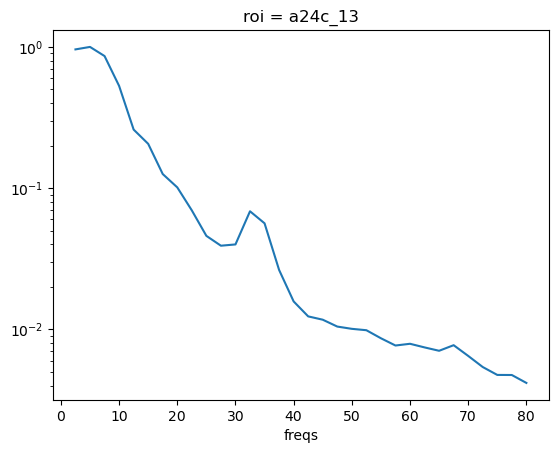

In [24]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
average_power_norm.sel(roi='a24c_13')[0].plot()
ax.set_yscale('log')

In [30]:
find_peaks(average_power_norm.sel(roi='a24c_13')[0], prominence=0.01)

(array([ 1, 12]),
 {'prominences': array([0.03950887, 0.02945528]),
  'left_bases': array([ 0, 10]),
  'right_bases': array([31, 31])})

In [34]:
peak_freqs[0]

<xarray.DataArray (roi: 68)> Size: 544B
array([ nan,  nan,  nan, 32.5, 17.5, 20. , 32.5, 17.5, 17.5, 32.5, 32.5,
       32.5, 32.5, 32.5, 32.5, 17.5, 32.5, 32.5, 32.5, 67.5, 67.5, 32.5,
       32.5, 32.5,  nan,  nan,  nan, 32.5, 32.5, 42.5,  nan, 32.5,  7.5,
        7.5,  7.5, 32.5,  7.5, 10. , 10. ,  7.5,  nan,  nan,  nan,  7.5,
        7.5,  nan,  7.5,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  5. ,  nan,  nan,  nan,
        nan,  nan])
Coordinates:
  * roi      (roi) <U11 3kB 'a14_4' 'a12_9' 'a46V_10' ... 'V1_251' 'V1_252'